Dimensionality reduction in various ways to lower the number of nodes into one that works for Gaussian processes
- UMAPs / TSNE
- GP latent variable model https://pyro.ai/examples/gplvm.html

In [2]:
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from scipy.stats import wasserstein_distance
from scipy.stats.mstats import gmean
from sklearn import covariance
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import cosine

import sys
import os
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pickle
from scipy.sparse import csgraph
from scipy.optimize import linprog
from tqdm import tqdm
import ot
import random
import pandas as pd

from scipy.spatial.distance import euclidean

In [14]:
def process_data(
    otu_file_path,
    metadata_file_path,
    distance_matrix_file_path=None,
    sample_id="Sample",
    condition_id="Study.Group", phylo=False
):
    """
    Processes OTU table, metadata, and distance matrix files.

    Args:
        otu_file_path (str): Path to the OTU table file.
        metadata_file_path (str): Path to the metadata file.
        distance_matrix_file_path (str): Path to the distance matrix file.
        sample_id(str): Identifier of the column in metadata that contains the sample names.
        condition_id(str): Identified of the column in metadata that discriminates the experimental conditions.
    Returns:
        otu_table (pd.DataFrame): Processed OTU table.
        metadata (pd.DataFrame): Processed metadata.
        phylo_distances (np.ndarray): Phylogenetic distance matrix.
        labels: disease condition labels in the order of the OTU table.
        otu_tables_per_condition (array of pd.DataFrame): Processed OTU tables per condition.
    """

    # Read data
    if otu_file_path.endswith(".tsv"):
        otu_table_raw = pd.read_csv(otu_file_path, sep="\t", index_col=0)
    else:
        otu_table_raw = pd.read_csv(otu_file_path, index_col=0)
    
    if len(otu_table_raw) > len(otu_table_raw.columns):
        otu_table_raw = otu_table_raw.T
    
    if metadata_file_path.endswith(".tsv"):
        metadata = pd.read_csv(metadata_file_path, sep="\t")
    else:
        metadata = pd.read_csv(metadata_file_path)
    
    # Filter rows whose index starts with 'T1', 'T2', or 'T5'
    #otu_table = otu_table_raw[otu_table_raw.index.str.startswith(("T"))]
    otu_table = otu_table_raw
    print(len(otu_table.columns))
    # Ensure sample identifier is the index of the metadata DataFrame
    if sample_id in metadata.columns:
        metadata.set_index(sample_id, inplace=True)
    else:
        raise ValueError(
            "Check sample identifier:", sample_id, "is not a column in metadata."
        )

    # Find common samples and filter DataFrames
    common_samples = otu_table.index.intersection(metadata.index)
    otu_table = otu_table.loc[common_samples]
   
    metadata = metadata.loc[common_samples]
    metadata = metadata.sort_values(condition_id)
    # Reindex OTU table to match metadata order
    otu_table = otu_table.reindex(metadata.index)

    # Ensure condition identified is the index of the metadata DataFrame
    if condition_id not in metadata.columns:
        raise ValueError(
            "Check condition identifier:", condition_id, "is not a column in metadata."
        )
    else:
        labels = metadata[condition_id].to_numpy()

    # Drop zero-everywhere columns and normalize OTU table
    cols_to_drop = otu_table.columns[otu_table.eq(0).all()]
    otu_table = otu_table.drop(cols_to_drop, axis=1)
    otu_table = otu_table.div(otu_table.sum(axis=1), axis=0) #Normalise to relative abundances
    

    #print(otu_table.head())
    print(otu_table.shape)
    
    #Create grouped data by averaging within condition
    otu_table_grouped = pd.DataFrame(columns=otu_table.columns) 
    for label in metadata[condition_id].unique():
        # Select samples for the current condition
        samples = metadata[metadata[condition_id] == label].index 
        
        # Create a sub-dataframe with samples for the current condition
        df_condition = otu_table.loc[samples]
        print(label, "# samples: ", len(df_condition))
        # Calculate the average abundance for each OTU (column)
        average_abundance = df_condition.mean(axis=0)
        
        otu_table_grouped.loc[label] = average_abundance 

    if distance_matrix_file_path != None:
        # Read and filter phylogenetic distances
        phylo_distances = pd.read_csv(distance_matrix_file_path, index_col=0)
        phylo_distances = phylo_distances.loc[
            otu_table.columns, otu_table.columns
        ].to_numpy()
    
    else: 
        phylo_distances = pd.DataFrame()
    return otu_table, metadata, phylo_distances, labels, otu_table_grouped

feature_table, metadata, phylo_distances, labels, otu_table_grouped  = process_data(
    "/Users/nandini.gadhia/Documents/projects/gp_omics/data/rvc/OTU_table_full.csv",
    "/Users/nandini.gadhia/Documents/projects/gp_omics/data/rvc/metadata.tsv", sample_id='Sample-ID', condition_id='Group ID')

features = feature_table.to_numpy()

740
(88, 740)
MV-C # samples:  20
UV-C # samples:  20
UV-C10 # samples:  8
UV-UC # samples:  20
V-C # samples:  20


Iter 10/20 - Loss: 1045.952
Iter 20/20 - Loss: 1046.667
Training finished.


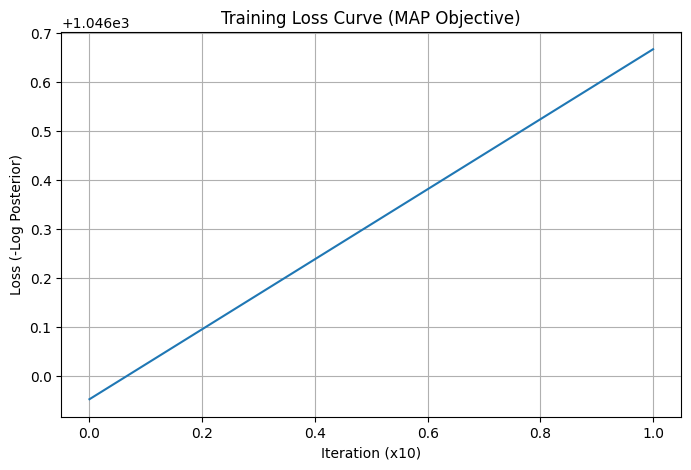

IndexError: boolean index did not match indexed array along axis 0; size of axis is 88 but size of corresponding boolean axis is 200

<Figure size 1000x800 with 0 Axes>

In [24]:
import os
import traceback
import numpy as np
import pandas as pd
from scipy.stats.mstats import gmean
import torch
import gpytorch
import matplotlib.pyplot as plt

Y = torch.tensor(features, dtype=torch.float32)
Y = (Y - Y.mean(dim=0)) / Y.std(dim=0)

n_points = Y.shape[0]
data_dim = Y.shape[1]
latent_dim = 80

# GPLVM model definition
class GPLVM(gpytorch.models.ExactGP):
    def __init__(self, n_points, latent_dim):
        # A placeholder for targets, which will be updated in the training loop
        train_x_placeholder = torch.randn(n_points, latent_dim)
        train_y_placeholder = torch.zeros(n_points)
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        
        super().__init__(train_x_placeholder, train_y_placeholder, likelihood)
        
        self.X = torch.nn.Parameter(torch.randn(n_points, latent_dim))

        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=latent_dim)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

model = GPLVM(n_points, latent_dim)
targets = [Y[:, i] for i in range(data_dim)]


optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)


student_t_prior = torch.distributions.StudentT(df=3.0, loc=0.0, scale=1.0)
#laplace_prior = torch.distributions.Laplace(loc=0.0, scale=1.0)

n_iterations = 20
losses = []
for i in range(n_iterations):
    optimizer.zero_grad()
    
    # Calculate the log-likelihood part of the loss
    # This is the sum of MLLs over all output dimensions
    log_likelihood_loss = 0
    for j in range(data_dim):
        model.set_train_data(inputs=model.X, targets=targets[j], strict=False)
        output = model(model.X)
        log_likelihood_loss -= mll(output, targets[j])

    log_prior_loss = -student_t_prior.log_prob(model.X).sum()
    #log_prior_loss = -laplace_prior.log_prob(model.X).sum()


    # The total loss is the MAP objective: -log p(Y|X) - log p(X)
    #total_loss = log_likelihood_loss + log_prior_loss #use this one for laplace or student's t prior
    total_loss = log_likelihood_loss #use this one for Gaussian prior

    total_loss.backward()
    optimizer.step()
    if (i + 1) % 10 == 0:
        print(f"Iter {i+1}/{n_iterations} - Loss: {total_loss.item():.3f}")
        losses.append(total_loss.item())

print("Training finished.")

# Plotting the training loss curve
plt.figure(figsize=(8, 5))
plt.plot(losses)
plt.title("Training Loss Curve (MAP Objective)")
plt.xlabel("Iteration (x10)")
plt.ylabel("Loss (-Log Posterior)")
plt.grid(True)
plt.show()

model.eval()
with torch.no_grad():
    X_latent = model.X.detach().numpy()

plt.figure(figsize=(10, 8))
controls = X_latent[labels_binary == 0]
cases = X_latent[labels_binary == 1]

plt.scatter(controls[:, 0], controls[:, 1], c='blue', label='Control (0)', alpha=0.7)
plt.scatter(cases[:, 0], cases[:, 1], c='red', label='Case (1)', alpha=0.7)

plt.title("GPLVM: Learned 2D Latent Space with Student's T Prior", fontsize=16)
plt.xlabel("Latent Dimension 1", fontsize=12)
plt.ylabel("Latent Dimension 2", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [25]:
X_latent_df = pd.DataFrame(X_latent, columns=[f'Latent_{i+1}' for i in range(latent_dim)])
X_latent_df = pd.DataFrame(X_latent, columns=[f'Latent_{i+1}' for i in range(latent_dim)])
X_latent_df.to_csv('/Users/nandini.gadhia/Documents/projects/gp_omics/data/rvc/OTU_table_rvc_data_latent_normal.csv', index=False)

In [26]:
X_latent_df

,Latent_1,Latent_2,Latent_3,Latent_4,Latent_5,Latent_6,Latent_7,Latent_8,Latent_9,Latent_10,...,Latent_71,Latent_72,Latent_73,Latent_74,Latent_75,Latent_76,Latent_77,Latent_78,Latent_79,Latent_80
0,0.335042,1.195338,1.092071,-0.551322,0.172520,-0.171593,0.918709,-0.016765,0.138133,-0.263914,...,-0.711456,0.581052,1.301148,-0.960652,0.092093,-1.029361,0.810357,-0.282053,0.235302,-0.042608
1,0.890321,-1.109336,0.697728,-0.416646,-1.901944,-1.380348,-1.183710,1.082680,2.157345,-1.787099,...,0.490339,0.744111,1.273197,-1.504526,0.133569,0.919165,-0.270744,-0.475018,-0.465849,-0.652361
2,-1.833653,1.690528,1.419690,-0.756806,-0.296516,-0.863323,-0.060175,-0.103868,1.242407,0.081163,...,1.192059,0.050443,-0.186069,1.285291,-1.174357,0.298880,0.683388,-0.790291,0.630167,0.514638
3,1.856633,0.113432,-1.003553,0.372221,-0.174081,0.237346,-0.384729,0.218304,0.478727,0.751153,...,-1.912764,1.165629,0.125036,-1.189801,-0.551342,0.798381,-1.259148,0.719153,1.048407,-2.194862
4,-1.233862,0.821640,1.582681,-0.872732,-0.160515,-0.032062,2.098308,-1.119881,-2.039532,-0.218583,...,-0.370860,-0.634702,0.207630,1.037915,0.791381,1.665799,-0.045045,1.182485,0.553448,0.917407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,0.335544,0.620086,-1.301897,-0.660039,0.278435,0.500823,0.106328,0.858123,-1.647268,1.177473,...,0.863470,-0.274416,2.258715,0.483493,0.248890,-0.453466,1.511714,0.153932,1.905376,-0.370849
84,1.100731,-0.397341,-2.223612,-1.243454,-0.909735,-1.563610,-1.327054,0.946108,-1.708194,-0.860174,...,1.423137,-1.309764,-0.493787,1.220300,1.393934,-0.216532,0.134646,0.549657,2.041275,-0.683886
85,-0.702268,0.229001,2.326275,-0.680603,-1.273882,-0.695725,0.018003,0.180080,0.723238,0.795737,...,-0.962369,0.608374,-0.690910,-0.382722,-1.660327,-1.076126,-0.517875,-1.294673,-1.724504,1.492524
86,0.148885,-0.108657,1.411620,-0.264773,1.846800,0.690560,-1.783511,-2.501833,-0.817669,0.526233,...,0.521528,-2.046956,-0.206477,-1.447081,0.478131,-1.710879,0.854074,-0.242518,1.840843,1.279903
